In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# declare a base 
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Display MEASUREMENT TABLE first row columns and data in dictionary format

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ec823dded0>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [10]:
# Use inspector to view Measurement Table database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(most_recent_date.date)

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.

# Subtract 365 days from most recent date
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_data = pd.DataFrame(results, columns = ['Date', 'Precipitation'])
prcp_data.head()


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


<Figure size 1000x600 with 0 Axes>

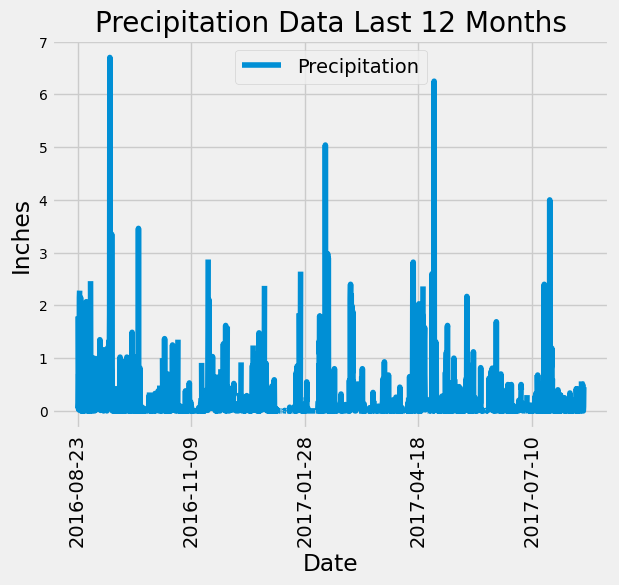

In [15]:
# Sort the dataframe by date
prcp_data.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
prcp_data.plot(x='Date', y='Precipitation', rot=90)

plt.yticks(fontsize=10)  # Adjust the fontsize as needed

plt.title("Precipitation Data Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Use inspector to view Station Table database
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
print(total_stations)

[(9,)]


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.tobs).label('observation_count')
).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == station_id).all()

# Unpack the results
min_temp, max_temp, avg_temp = temp_stats[0]

# Print the results
# Xpert Learning Assistant suggestion to print with additional text
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp}°F")

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


<Figure size 1000x600 with 0 Axes>

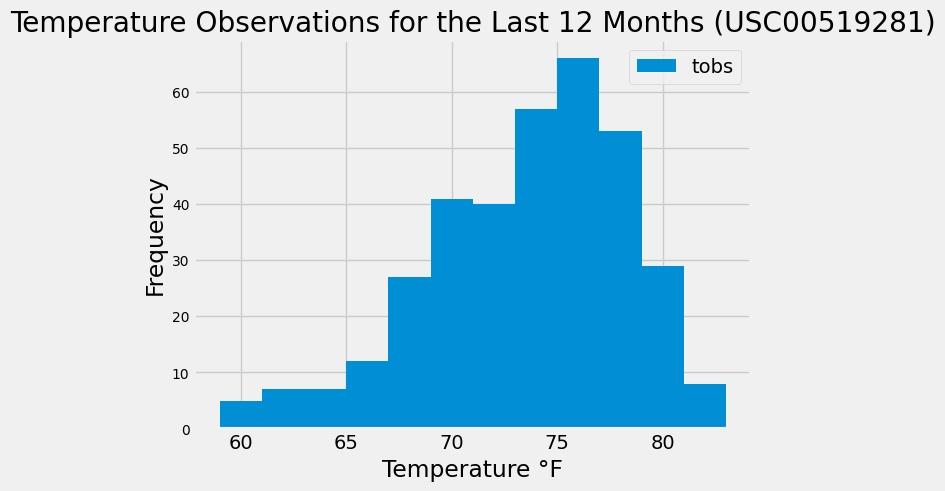

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_id = 'USC00519281'
last_12_months_tobs = session.query(
    Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= dt.date(2016, 8, 23)).\
    filter(Measurement.date <= dt.date(2017, 8, 23)).\
    filter(Measurement.station == station_id).all()

# Convert the results to a Pandas DataFrame
last_12_months_tobs = pd.DataFrame(last_12_months_tobs, columns=['date', 'tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
last_12_months_tobs.plot(kind="hist", bins = 12)

plt.title("Temperature Observations for the Last 12 Months (USC00519281)")
plt.xlabel("Temperature °F")
plt.ylabel("Frequency")
plt.yticks(fontsize=10)

plt.show()

# Close Session

In [22]:
# Close Session
session.close()